In [1]:
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
import pickle
import os
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
%reload_ext dotenv
%dotenv -o

CITY_NAME = os.environ["CITY_NAME"]
CITY_SLUG = os.environ["CITY_SLUG"]
print(f"City name: {CITY_NAME}")
print(f"City slug: {CITY_SLUG}")

City name: Cambridge, MA, USA
City slug: cambridge_ma


## Read data

This shouldn't take longer than ~40 sec.

### Load graph, separate to nodes and edges

In [7]:
# ~15 sec
with open(f"./data/{CITY_SLUG}_networkx_graph.pkl", "rb") as fin:
    G = pickle.load(fin)
    
print(f"Graph has:")
print(f"  {G.number_of_nodes():,} nodes")
print(f"  {G.number_of_edges():,} edges")

Graph has:
  1,830 nodes
  4,110 edges


In [8]:
import warnings
warnings.filterwarnings("ignore")

def plot_base_network():
    %matplotlib agg
    fig, ax = plt.subplots()
    ox.plot_graph(
        G, ax=ax,
        figsize=(8, 8),
        bgcolor="#fff", edge_color="#000", node_color="#000",
        node_size=5, edge_linewidth=0.5
    )
    %matplotlib inline
    return fig, ax

In [9]:
nodes, edges = ox.graph_to_gdfs(G)

### Load boba shop locations

In [10]:
# Hack from https://stackoverflow.com/questions/71907567/valueerror-geodataframe-does-not-support-multiple-columns-using-the-geometry-co
boba_gdf = gpd.read_file(f"./data/{CITY_SLUG}_boba_shops.csv",
                         GEOM_POSSIBLE_NAMES="geometry", 
                         KEEP_GEOM_COLUMNS="NO")
boba_gdf = boba_gdf[["id", "location", "geometry"]]
boba_gdf.head()

,id,location,geometry
0,cNNTPEqz5uMY5cjCW7M8oA,"{'address1': '425 Massachusetts Ave', 'address...",POINT (-71.10147 42.36408)
1,sKkCCr951o-wtPccNfPINw,"{'address1': '100 Cambridgeside Pl', 'address2...",POINT (-71.07599 42.36878)
2,RzcDKKBkxy1JPCEFoGrV8A,"{'address1': '100 Cambridgeside Pl', 'address2...",POINT (-71.07599 42.36878)
3,996jyfv8Q6yyxJDFb8x4qA,"{'address1': '605 Massachusetts Ave', 'address...",POINT (-71.10298 42.36517)
4,RFMiG4t35kNr4Iz3ndu3nw,"{'address1': '955 Massachusetts Ave', 'address...",POINT (-71.11007 42.36911)


### Generate intersections of nearest boba shops

In [11]:
nodes.head(1)

,y,x,highway,street_count,geometry
osmid,,,,,
61182955,42.385184,-71.116133,traffic_signals,4,POINT (-71.11613 42.38518)


In [12]:
end_nodes = set()

for _, row in boba_gdf.iterrows():
    x, y = row["geometry"].x, row["geometry"].y
    node = ox.nearest_nodes(G, x, y)
    end_nodes.add(node)
    for edge in G.in_edges(node):
        end_nodes.add(edge[0])

end_nodes = list(end_nodes)

In [13]:
print(len(end_nodes), len(boba_gdf))

40 13


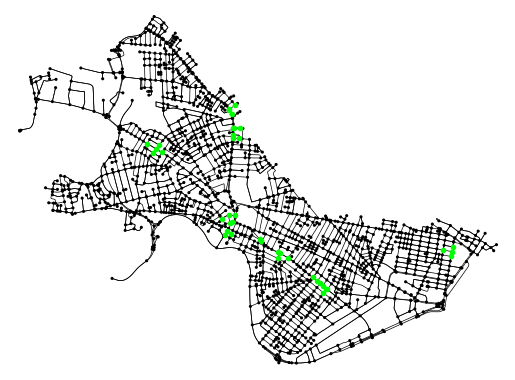

In [14]:
# Select rows of dataframe that match with endpoints
end_gdf = nodes.loc[end_nodes]

fig, ax = plot_base_network()
ax.plot(end_gdf["geometry"].x, end_gdf["geometry"].y, "o", markersize=3, c="#0f0")
fig

### Generate adjacency list

In [17]:
seen = set()

for edge in G.edges():
    if edge in seen:
        print(f"{edge} is duplicated!")

    seen.add(edge)

(61317369, 61317370) is duplicated!
(61317370, 61317369) is duplicated!
(61317525, 61317525) is duplicated!
(61321637, 61321674) is duplicated!
(61321701, 61321690) is duplicated!
(61321975, 61322001) is duplicated!
(61322537, 61322537) is duplicated!
(61323064, 61323157) is duplicated!
(61323129, 61323129) is duplicated!
(61323157, 61323064) is duplicated!
(61324241, 61329043) is duplicated!
(61325354, 61325354) is duplicated!
(61327562, 61327562) is duplicated!
(61330486, 61330514) is duplicated!
(61330514, 61330486) is duplicated!
(61332946, 61332946) is duplicated!
(765367885, 5555443284) is duplicated!
(5555443284, 765367885) is duplicated!


In [15]:
from collections import defaultdict
import re

adj = defaultdict(list)
for u, v in tqdm(G.edges()):
    data = G.get_edge_data(u, v)[0]
    print(data)
    if pd.isnull(data["maxspeed"]):
        maxspeed = 25
    else:
        maxspeed = int(re.fullmatch(r"(\d+) mph", data["maxspeed"]).group(1))
    
    t = data["length"]
    G[u][v]["time"] = t

  0%|          | 0/4110 [00:00<?, ?it/s]

{'osmid': 9429431, 'lanes': '2', 'name': 'Oxford Street', 'highway': 'tertiary', 'maxspeed': '20 mph', 'width': '15.2', 'oneway': False, 'reversed': True, 'length': 94.75899999999999, 'geometry': <LINESTRING (-71.116 42.385, -71.116 42.385, -71.116 42.384, -71.116 42.384)>}


TypeError: 'AtlasView' object does not support item assignment

## Generating random walks

In [ ]:
import random

In [ ]:
startY, startX = ox.geocoder.geocode("Harvard Yard, MA, USA")
start = ox.nearest_nodes(G, startX, startY)

print(f"Starting at osmid={start}:")
print(nodes.loc[start])

print(f"\n{nodes.loc[start].y}, {nodes.loc[start].x}")

In [ ]:
# Keep visiting nodes till we hit something in end_nodes
cur = start
t = 0
path = []

while cur not in end_nodes:
    path.append((cur, t))
    out_edges = G.out_edges(cur)

    for edge in out_edges:
        data = G.get_edge_data(edge)
        